In [1]:
%load_ext autoreload
%autoreload 2  
    
import config as cfg
import logging
from sca import plots, helpers as h

In [2]:
X, y, pts, ks = h.load_data(cfg.DATA_DIR / 'ascadv_clean.h5')

Parametry z [Machine Learning-Based AES Key Recovery via Side-Channel Analysis on the ASCAD Dataset](https://link.springer.com/chapter/10.1007/978-3-032-08649-5_21)

In [3]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pl_rf = make_pipeline(
    StandardScaler(),
    RFC(
        n_estimators=100, max_depth=20, 
        min_samples_leaf=10, n_jobs=-1,
        random_state=cfg.SEED
    )
)

In [4]:
score = h.cv(pl_rf, X, y, pts, ks, n_repeats=5, seed=cfg.SEED)
logging.info(f"Mean PI (RF, 2 splits, 5 repeats): {score:.2e}")

12:13:06: [1] Mean PI: 0.005
12:13:49: [2] Mean PI: 0.004
12:14:31: [3] Mean PI: 0.005
12:15:12: [4] Mean PI: 0.005
12:15:56: [5] Mean PI: 0.002
12:16:38: [6] Mean PI: 0.004
12:17:19: [7] Mean PI: 0.005
12:18:00: [8] Mean PI: 0.004
12:18:42: [9] Mean PI: 0.003
12:19:24: [10] Mean PI: 0.005
12:19:24: Mean PI (RF, 2 splits, 5 repeats): 4.13e-03


In [5]:
import pandas as pd
fi, feat_rank = h.feature_importances(pl_rf, X, y, pts, ks, seed=cfg.SEED)
pd.DataFrame({'FI': fi, "Feat Rank": feat_rank}).to_csv('data/rf_best_feats_idx.csv')

12:20:06: [1] Mean PI: 0.005


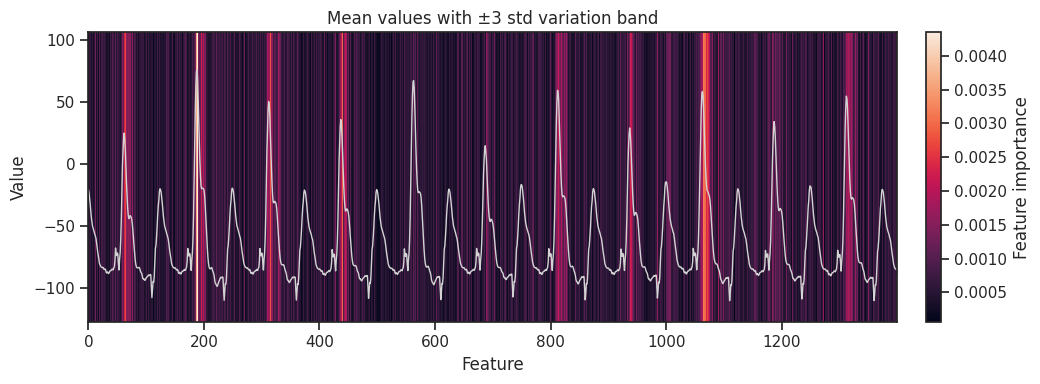

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')

def plot_mean_traces(X, color='black'):
    fig, ax = plt.subplots(figsize=(11, 4))
    m, sd = plots.mean_std(X)
    
    ax.plot(range(len(m)), m, linewidth=1, color=color, label="mean")
    plots.labs(plots.lim(ax, len(m)), xlab="Feature", ylab="Value", 
               title="Mean values with ±3 std variation band")
    
    plots.std_band(ax, m, sd).grid(True, linestyle="--", alpha=0.8)
    ax.legend(loc='upper right')
    return fig, ax

_, ax = plot_mean_traces(X, color='lightgray')

cmap = sns.color_palette('rocket', as_cmap=True)
norm = plt.Normalize(fi.min(), fi.max())

pcm = ax.pcolormesh(range(len(fi) + 1), ax.get_ylim(),
                    fi[None, :], norm=norm, cmap=cmap)

cbar = ax.figure.colorbar(pcm, ax=ax, pad=0.03)
cbar.set_label("Feature importance")

ax.legend().remove()
ax.figure.tight_layout()

In [ ]:
res = h.n_feats_search(pl_rf, X, y, pts, ks, feat_rank, range(25, 500, 25), seed=cfg.SEED)
res.to_csv('data/rf_best_feats.csv')
res

12:21:34: Mean PI (n_feats=25): -4.85e-02


In [ ]:
plt.plot(res['n_feats'], res['PI'])
plt.grid(True, linestyle='--')

In [ ]:
fig, ax = plot_mean_traces(X)

cmap = sns.color_palette('rocket_r', as_cmap=True)
norm = plt.Normalize(fi.min(), fi.max())

for i in feat_rank[:175]:
    ax.axvline(i, c=cmap(norm(fi[i])), alpha=0.5)

sm = plt.cm.ScalarMappable(norm, cmap)
cbar = fig.colorbar(sm, ax=ax, pad=0.03)
cbar.set_label("Feature importance")
fig.tight_layout()